In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

## Plot the experimental, initial simulation and iterated simulation curves

In [359]:
# Requiring that the interpolatedStrain must lie inside the range of strain
def interpolatedStressFunction(stress, strain, interpolatedStrain):
    # interpolated function fits the stress-strain curve data 
    interpolatedFunction = interp1d(strain, stress)
    # Calculate the stress values at the interpolated strain points
    interpolatedStress = interpolatedFunction(interpolatedStrain)
    return interpolatedStress

def getIndexBeforeStrainLevel(strain, level):
    for i in range(len(strain)):
        if strain[i] > level:
            return i - 1

def getIndexBeforeStrainLevelEqual(strain, level):
    for i in range(len(strain)):
        if strain[i] >= level:
            return i

def calculateInterpolatingStrains(mainStrain, limitingStrain, yieldStressStrainLevel, dropUpperEnd):
    x_max = limitingStrain.max() 
    indexUpper = getIndexBeforeStrainLevelEqual(mainStrain, x_max)
    indexLower = getIndexBeforeStrainLevel(mainStrain, yieldStressStrainLevel) 
    mainStrain = mainStrain[:indexUpper]
    mainStrain = mainStrain[indexLower:]
    # If the error: ValueError: A value in x_new is above the interpolation range occurs,
    # it is due to the the strain value of some simulated curves is higher than the last stress value
    # of the interpolated strain so it lies outside the range. You can increase the dropUpperEnd number to reduce the
    # range of the simulated curves so their stress can be interpolated
    # interpolatedStrain will be the interpolating strain for all curves (experimental, initial simulation and iterated simulation)
    interpolatedStrain = mainStrain
    if dropUpperEnd != 0:
        interpolatedStrain = mainStrain[:-dropUpperEnd]
    # Strain level is added to the interpolating strains
    interpolatedStrain = np.insert(interpolatedStrain, 1, yieldStressStrainLevel)
    return interpolatedStrain

In [381]:
def plotSimulations(initialSims, pathExp, pathSim, title, CPLaw, plotIterations = False, plotInterpolated = False):
    plt.figure(figsize=(10, 8))
    plt.rcParams.update({'font.size': 13})
    # The simulation curves from DAMASK are in true stress-true strain
    # preprocess them into flow curves in order to compare with the experimental curve
    initial_data = np.load(f'{pathSim}/initial_simulations.npy', allow_pickle=True)
    initial_data = initial_data.tolist()
    if CPLaw == "PH":
        convertUnit = 1
    elif CPLaw == "DB":
        convertUnit = 1e-6
    if plotIterations:
        full_data = np.load(f'{pathSim}/simulations.npy', allow_pickle=True)
        full_data = full_data.tolist()
    
    for curve in initial_data.values():
        trueStress = curve[1] * convertUnit
        truePlasticStrain = curve[0] 
        plt.plot(truePlasticStrain, trueStress, c='orange', alpha=0.2)
    plt.plot(truePlasticStrain, trueStress, label = f"Initial simulations x{initialSims}",c='orange', alpha=0.2)
    allstrains = list(map(lambda x: x[0], list(initial_data.values())))
    simStrain = np.array(allstrains).mean(axis=0)

    exp_curve = pd.read_csv(pathExp)
    exp_stress = exp_curve.iloc[:,0] * convertUnit # Getting the experimental stress
    exp_strain = exp_curve.iloc[:,1] # Getting the experimental strain    
    interpolatedStrain = calculateInterpolatingStrains(simStrain, exp_strain, 0.002, 2)
    print(interpolatedStrain)
    exp_target = interpolatedStressFunction(exp_stress, exp_strain, interpolatedStrain)
    if plotInterpolated:
        plt.plot(interpolatedStrain, exp_target, label = f"Experimental curve", marker='^', markersize=8)
    else: 
        plt.plot(exp_strain, exp_stress, label = f"Experimental curve")
    
    # If you want to plot only some specific iterations, set plotExactIterationCheck to True
    # and specify the iteration number
    plotExactIterationCheck = True
    plotExactIteration = [18]
    if plotIterations:
        if CPLaw == "PH":
            titleParams = "Parameter: (alpha, h0, tau0, taucs)"
        elif CPLaw == "DB":
            titleParams = "Parameter: (dipole, islip, omega, p, q, tausol)"
        plt.plot([], [], ' ', label=titleParams)
        parameters = list(full_data)[initialSims:]
        strainstress = list(full_data.values())[initialSims:]
        simCurves = zip(parameters, strainstress)
        i = 0
        for parameter, strainstress in simCurves:
            trueStress = strainstress[1] * convertUnit
            truePlasticStrain = strainstress[0]
            sim_target = interpolatedStressFunction(trueStress, truePlasticStrain, interpolatedStrain)
            i += 1
            if plotExactIterationCheck:
                if i in plotExactIteration:
                    # print(calculateIndex(trueStress, truePlasticStrain))
                    if plotInterpolated: 

                        plt.plot(interpolatedStrain, sim_target, label = f"Iteration {i}: {parameter}", marker='.', markersize=8)
                    else: 
                        print(sim_target[1])
                        plt.plot(truePlasticStrain, trueStress, label = f"Iteration {i}: {parameter}")
            else: 
                if plotInterpolated: 
                    plt.plot(interpolatedStrain, sim_target, label = f"Iteration {i}: {parameter}", marker='.', markersize=8)
                else: 
                    plt.plot(truePlasticStrain, trueStress, label = f"Iteration {i}: {parameter}")
    # Uncomment these lines to have a closer view. Change the limit as you want to see better
    # plt.xlim([0.0019,0.003])
    # plt.ylim([0,400])
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel = "Strain (-)", fontsize=16)
    plt.ylabel(ylabel = "Stress (MPa)", fontsize=16)
    plt.axvline(x = 0.002, color = 'black', label = 'Yield stress at strain level = 0.002', alpha=0.4)
    plt.legend(loc=4, prop={'size': 12})
    plt.show()
    return simStrain, exp_stress, exp_strain


[0.00197344 0.002      0.0021629  0.0023528  0.00254306 0.00273359
 0.00321078 0.00368878 0.00416728 0.00464609 0.0051251  0.00560425
 0.00608348 0.00656277 0.00704209 0.00752142 0.00800075 0.00848007
 0.00895937 0.00943864 0.00991787 0.01039706 0.0108762  0.01135529
 0.01183432 0.01231328 0.01279217 0.01327099 0.01374974 0.0142284
 0.01470699 0.01518549 0.02258939 0.02996429 0.03730531 0.04460925
 0.05187385 0.05909738 0.06627853 0.0734163  0.08051009 0.08755945
 0.09456403 0.10152354 0.10843778 0.11530685 0.12213101 0.12891052
 0.13564567 0.14233678 0.14898422 0.15558842 0.15982644 0.16404675
 0.16824945]
74.1208997290077


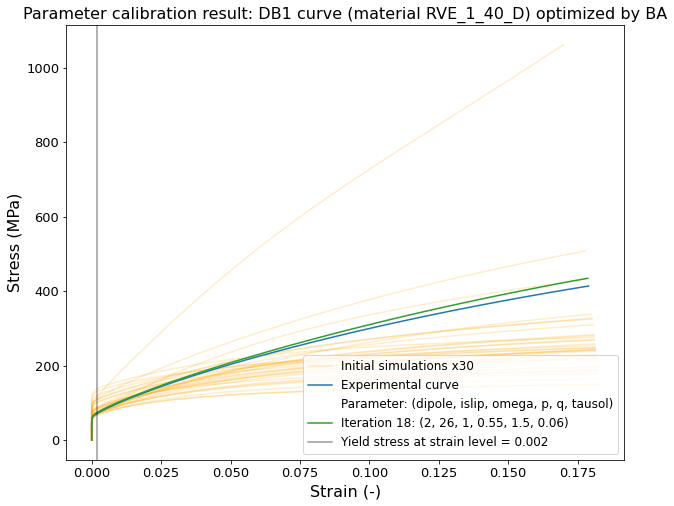

In [382]:
# Please change these configurations
# Number of initial simulations
initialSims = 30

# material used
material = "RVE_1_40_D"
# material = "512grains512"

# Used algorithm
# algorithm = "GA"
algorithm = "BA"

# Crystal plasticity law
# CPLaw = "PH"
CPLaw = "DB"

# Curve index
curveIndex = 1
# curveIndex = 2
# curveIndex = 3

titleOptimized = f"Parameter calibration result: {CPLaw}{curveIndex} curve (material {material}) optimized by {algorithm}"
titleNoOptimized = f"Initial simulations and experimental curve of {CPLaw}{curveIndex} (material {material})"
pathExp = f"targets_{material}/{CPLaw}{curveIndex}.csv"
pathSim = f"results_{material}/{CPLaw}{curveIndex}_{algorithm}"

# Plot only initial simulations and experimental curve
# simStrain, exp_stress, exp_strain = plotSimulations(initialSims, pathExp, pathSim, titleNoOptimized, CPLaw)
# Plot initial simulations, experimental curve and iterated simulation results
simStrain, exp_stress, exp_strain = plotSimulations(initialSims, pathExp, pathSim, titleOptimized, CPLaw, True)
# Plot initial simulations, interpolated experimental curve and interpolated iterated simulation results
# simStrain, exp_stress, exp_strain = plotSimulations(initialSims, pathExp, pathSim, titleOptimized, CPLaw, True, True)

## Plot fitness for the curves

In [362]:
import numpy as np
from math import *

################################################
# Yield stress objective and fitness functions #
################################################
def Y1(exp_stress, sim_stress):
    expYieldStress = exp_stress[1]
    simYieldStress = sim_stress[1] 
    return abs(expYieldStress - simYieldStress)

def Y2(exp_stress, sim_stress, interpolating_strain):
    expSlope = (exp_stress[2] - exp_stress[0]) /(interpolating_strain[2] - interpolating_strain[0])
    simSlope = (sim_stress[2] - sim_stress[0]) /(interpolating_strain[2] - interpolating_strain[0])
    return abs(expSlope - simSlope)

def fitness_yield(exp_stress, sim_stress, interpolating_strain, wy1, wy2):
    return (wy1 * Y1(exp_stress, sim_stress) + wy2 * Y2(exp_stress, sim_stress, interpolating_strain))

################################################
# Yield stress objective and fitness functions #
################################################
def Y1(exp_stress, sim_stress):
    expYieldStress = exp_stress[1]
    simYieldStress = sim_stress[1] 
    return abs(expYieldStress - simYieldStress)

def Y2(exp_stress, sim_stress, interpolating_strain):
    expSlope = (exp_stress[2] - exp_stress[0]) /(interpolating_strain[2] - interpolating_strain[0])
    simSlope = (sim_stress[2] - sim_stress[0]) /(interpolating_strain[2] - interpolating_strain[0])
    return abs(expSlope - simSlope)

def fitness_yield(exp_stress, sim_stress, interpolating_strain, wy1, wy2):
    return (wy1 * Y1(exp_stress, sim_stress) + wy2 * Y2(exp_stress, sim_stress, interpolating_strain))

#############################################
# Hardening objective and fitness functions #
#############################################

def H1(exp_stress, sim_stress): 
    return np.sqrt(np.sum(np.square(exp_stress - sim_stress))/np.sum(np.square(exp_stress)))

def H2(exp_stress, sim_stress, interpolating_strain): 
    exp_stress_d1 = np.diff(exp_stress)/np.diff(interpolating_strain)  
    sim_stress_d1 = np.diff(sim_stress)/np.diff(interpolating_strain)
    return np.sqrt(np.sum(np.square(sim_stress_d1 - exp_stress_d1))/np.sum(np.square(exp_stress_d1)))

def H3(exp_stress, sim_stress):
    return np.max(np.sqrt(np.square(exp_stress - sim_stress)/sum(np.square(exp_stress))))

def H4(exp_stress, sim_stress, interpolating_strain):
    exp_stress_d1 = np.diff(exp_stress)/np.diff(interpolating_strain)
    sim_stress_d1 = np.diff(sim_stress)/np.diff(interpolating_strain)
    return np.max(np.sqrt(np.square(sim_stress_d1 - exp_stress_d1)/np.sum(np.square(exp_stress_d1))))

def fitness_hardening(exp_stress, sim_stress, interpolating_strain, wh1, wh2, wh3, wh4):
    return ( wh1*H1(exp_stress, sim_stress) + wh2*H2(exp_stress, sim_stress, interpolating_strain) 
            + wh3*H3(exp_stress, sim_stress) + wh4*H4(exp_stress, sim_stress, interpolating_strain))

###############################
# Stopping criteria functions #
###############################

wy1 = 0.999
wy2 = 0.001   
wh1 = 0.7
wh2 = 0.05
wh3 = 0.2
wh4 = 0.05

In [363]:

plt.rc('font', size=20)          # controls default text sizes

# Results of each objective functions
resY1 = []
resY2 = []
resH1 = []
resH2 = []
resH3 = []
resH4 = []
resHardening = []
resYield = []

if CPLaw == "PH":
    convertUnit = 1
elif CPLaw == "DB":
    convertUnit = 1e-6
    
full_data = np.load(f'{pathSim}/simulations.npy', allow_pickle=True)
full_data = full_data.tolist()

numberOfGen = len(full_data) - initialSims

# Fix this labels for the correct number of generations
labelsModel = ['1st', '2nd', '3rd', '4th','5th', '6th', '7th', '8th', '9th', '10th', 
               '11th', '12th','13th','14th','15th','16th','17th','18th','19th','20th']
labels = labelsModel[:numberOfGen]

interpolatedStrain = calculateInterpolatingStrains(simStrain, exp_strain, 0.002, 2)
exp_target = interpolatedStressFunction(exp_stress, exp_strain, interpolatedStrain)
print("Experimental stress")
print(exp_target)
print("Interpolated strains is: ")
print(interpolatedStrain)
parameters = list(full_data)[initialSims:]
strainstress = list(full_data.values())[initialSims:]
simCurves = zip(parameters, strainstress)

for parameter, strainstress in simCurves:
    trueStress = strainstress[1]  * convertUnit
    truePlasticStrain = strainstress[0]
    sim_stress = interpolatedStressFunction(trueStress, truePlasticStrain, interpolatedStrain)
    print("sim stress is: ")
    print(sim_stress)
    resH1.append(H1(exp_target, sim_stress))
    resH2.append(H2(exp_target, sim_stress, interpolatedStrain))
    resH3.append(H3(exp_target, sim_stress))
    resH4.append(H4(exp_target, sim_stress, interpolatedStrain))
    resY1.append(Y1(exp_target, sim_stress))
    resY2.append(Y2(exp_target, sim_stress, interpolatedStrain))
    resYield.append(fitness_yield(exp_target, sim_stress, interpolatedStrain, wy1, wy2))
    resHardening.append(fitness_hardening(exp_target, sim_stress, interpolatedStrain, wh1, wh2, wh3, wh4))

'''
print("Y1 is: ")
print(resY1)
print("Y2 is: ")
print(resY2)
print("D1 is: ")
print(resD1)
print("D2 is: ")
print(resD2)
print("D3 is: ")
print(resD3)
print("D4 is: ")
print(resD4)
'''

width = 0.5       # Width of the bar
size = 16   # font size
figsize = (10,8) # figure size

WY1 = np.array(resY1) * wy1
WY2 = np.array(resY2) * wy2
WH1 = np.array(resH1) * wh1
WH2 = np.array(resH2) * wh2
WH3 = np.array(resH3) * wh3
WH4 = np.array(resH4) * wh4

print("Weighted Y1 is:")
print(WY1)
print("Weighted Y2 is")
print(WY2)
print("Yield stress fitness score")
print(resYield)
print("Weighted H1 is:")
print(WH1)
print("Weighted H2 is")
print(WH2)
print("Weighted H3 is:")
print(WH3)
print("Weighted H4 is:")
print(WH4)
print("Hardening fitness score")
print(resHardening)

Experimental stress
[ 71.75221488  71.86962268  72.57221212  73.37417492  74.16149005
  74.9365539   76.82476172  78.67072216  80.47681882  82.24976674
  83.99377666  85.71177905  87.40610808  89.07855511  90.73052356
  92.36322144  93.97769866  95.57487786  97.15558046  98.72055735
 100.27049837 101.80602985 103.32771478 104.83606374 106.33155603
 107.81463879 109.28573076 110.7452294  112.19350421 113.6309062
 115.05776016 116.47437211 137.30432844 156.4776228  174.38083999
 191.26958571 207.30234024 222.59073892 237.21425391 251.23076877
 264.68790924 277.62561912 290.075153   302.06073587 313.60777986
 324.73548961 335.46186874 345.80683283 355.78589685 365.4155739
 374.71167053 383.69720137 389.32460251 394.82739533 400.20850445]
Interpolated strains is: 
[0.00197344 0.002      0.0021629  0.0023528  0.00254306 0.00273359
 0.00321078 0.00368878 0.00416728 0.00464609 0.0051251  0.00560425
 0.00608348 0.00656277 0.00704209 0.00752142 0.00800075 0.00848007
 0.00895937 0.00943864 0.009

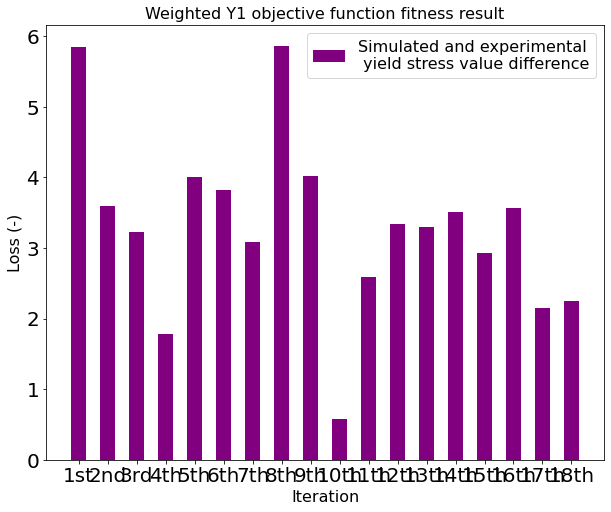

In [364]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WY1, width, label='Simulated and experimental\n yield stress value difference', color = "purple")
ax.set_title('Weighted Y1 objective function fitness result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': 16})
plt.show()

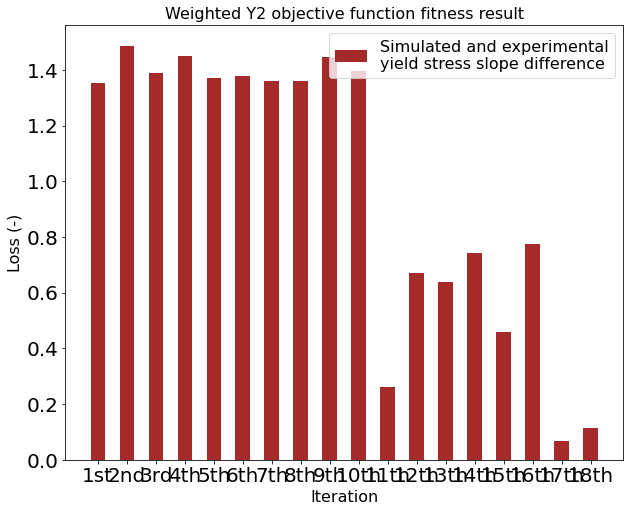

In [373]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WY2, width, label='Simulated and experimental\nyield stress slope difference', color = "brown")
ax.set_title('Weighted Y2 objective function fitness result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': 16})
plt.show()

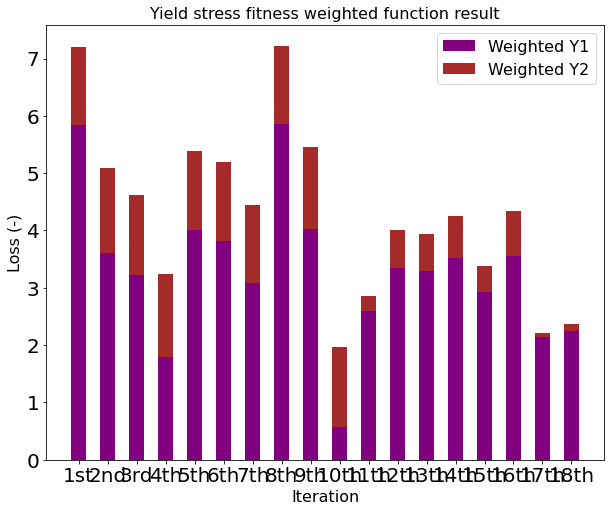

In [366]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WY1, width, label='Weighted Y1', color = "purple")
ax.bar(labels, WY2, width, bottom=WY1 , label='Weighted Y2', color = "brown")

ax.set_title('Yield stress fitness weighted function result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': size})
plt.show()

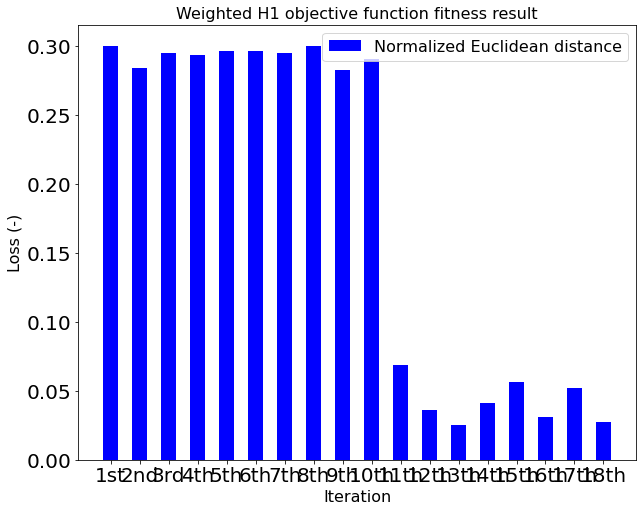

In [367]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WH1, width, label='Normalized Euclidean distance', color = "blue")
ax.set_title('Weighted H1 objective function fitness result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': 16})
plt.show()

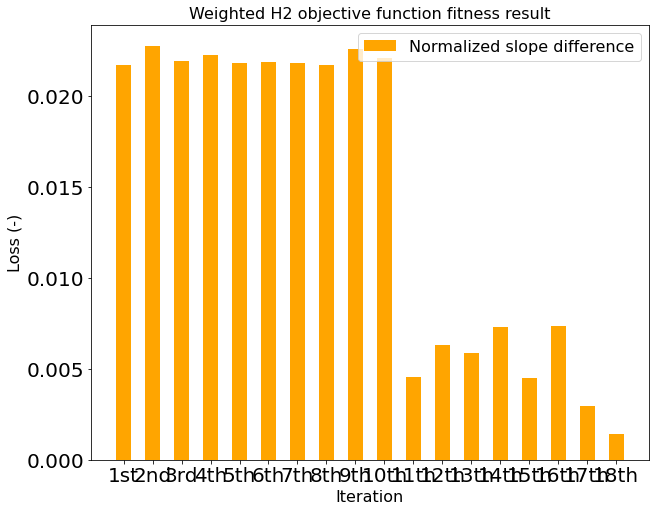

In [368]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WH2, width, label='Normalized slope difference', color = "orange")
ax.set_title('Weighted H2 objective function fitness result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': size})
plt.show()

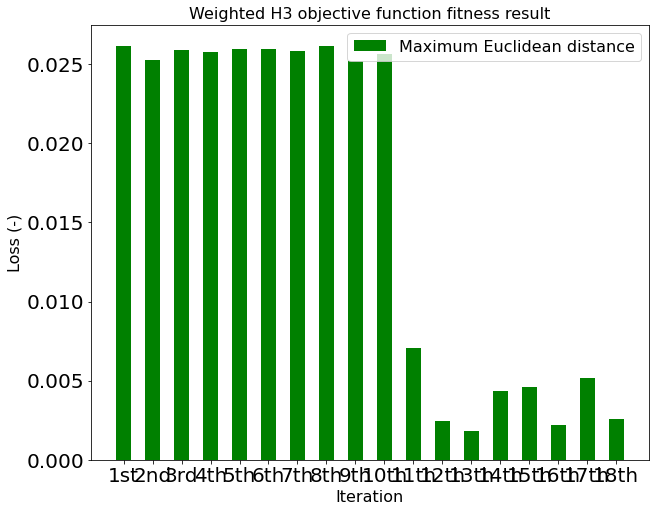

In [369]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WH3, width, label='Maximum Euclidean distance', color = "green")
ax.set_title('Weighted H3 objective function fitness result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': size})
plt.show()

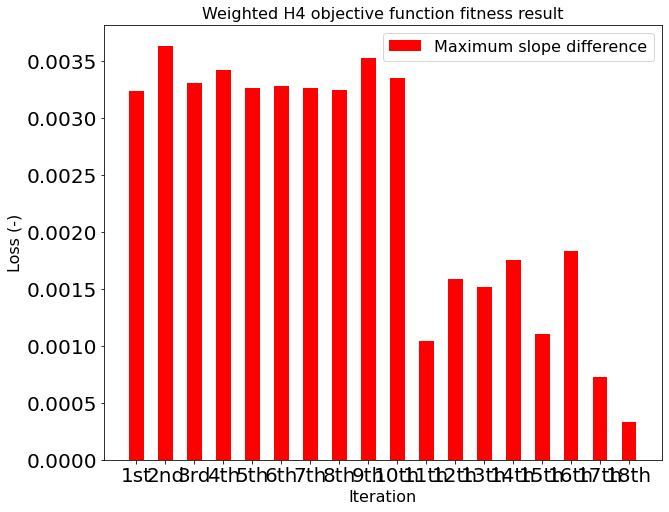

In [370]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WH4, width, label='Maximum slope difference', color = "red")
ax.set_title('Weighted H4 objective function fitness result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': size})
plt.show()

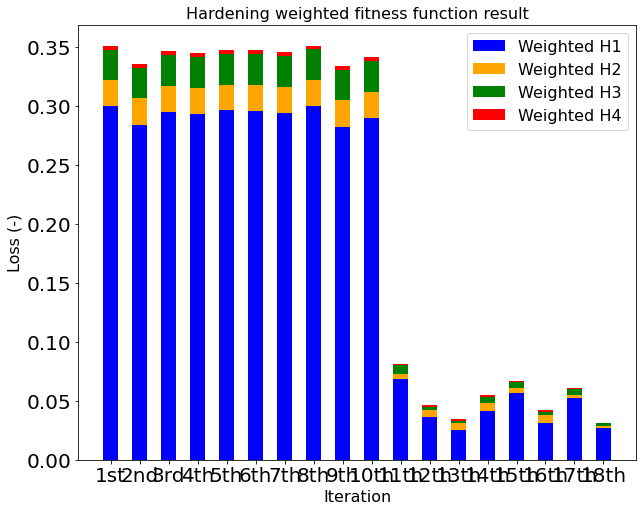

In [371]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(labels, WH1, width, label='Weighted H1', color = "blue")
ax.bar(labels, WH2, width, bottom=WH1 , label='Weighted H2', color = "orange")
ax.bar(labels, WH3, width, bottom=WH1+WH2, label='Weighted H3', color = "green")
ax.bar(labels, WH4, width, bottom=WH1+WH2+WH3, label='Weighted H4', color = "red")

ax.set_title('Hardening weighted fitness function result',size=size)
ax.set_ylabel('Loss (-)',size=size)
ax.set_xlabel("Iteration",size=size)
ax.legend(prop={'size': size})
plt.show()

## Interpolated points plot

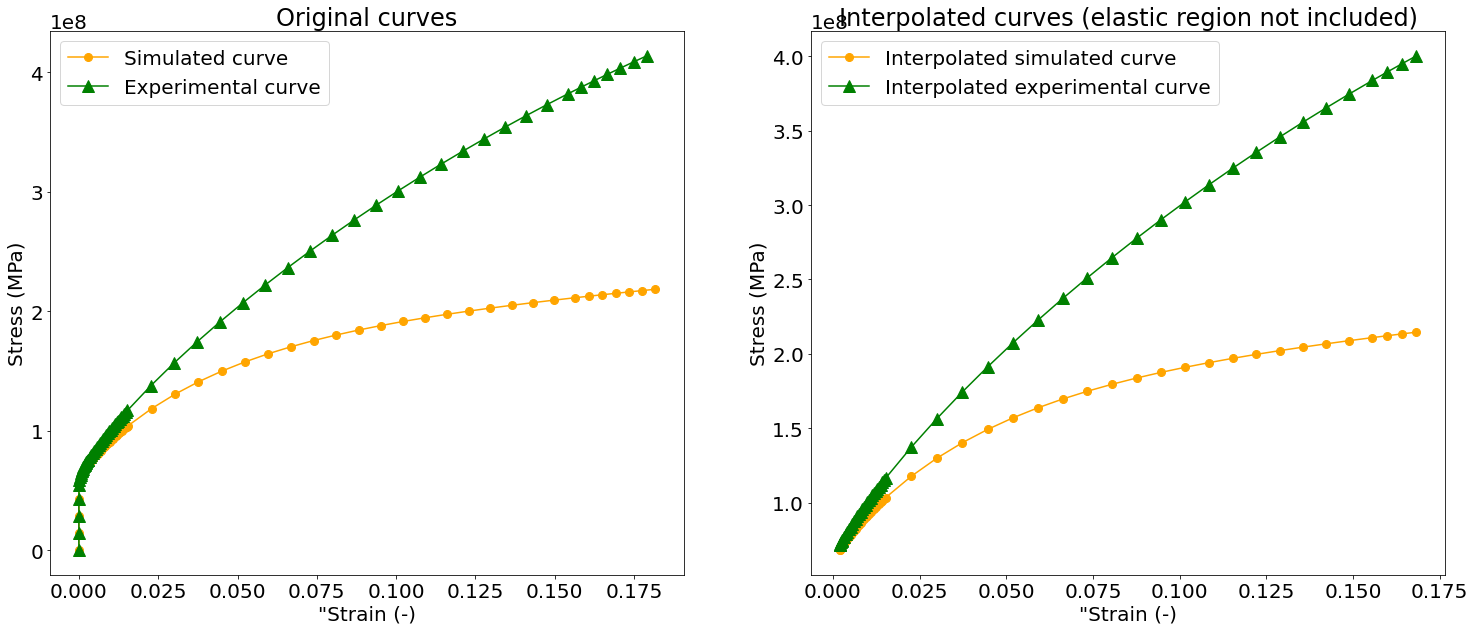

In [372]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
# The simulation curves from DAMASK are in true stress-true strain
# preprocess them into flow curves in order to compare with the experimental curve
initial_data = np.load(f'{pathSim}/initial_simulations.npy', allow_pickle=True)
initial_data = initial_data.tolist()

simCurve = list(initial_data.values())[0]
trueStress = simCurve[1]
truePlasticStrain = simCurve[0]
ax1.plot(truePlasticStrain, trueStress, label = f"Simulated curve",c='orange', marker='.', markersize=16)
allstrains = list(map(lambda x: x[0], list(initial_data.values())))
simStrain = np.array(allstrains).mean(axis=0)


exp_curve = pd.read_csv(pathExp)
exp_stress = exp_curve.iloc[:,0] # Getting the experimental stress
exp_strain = exp_curve.iloc[:,1] # Getting the experimental strain
ax1.plot(exp_strain, exp_stress, label = f"Experimental curve", c="green", marker='^', markersize=12)

interpolatedStrain = calculateInterpolatingStrains(simStrain, exp_strain, 0.002, 2)
exp_target = interpolatedStressFunction(exp_stress, exp_strain, interpolatedStrain)
sim_target = interpolatedStressFunction(trueStress, truePlasticStrain, interpolatedStrain)
ax2.plot(interpolatedStrain, sim_target, label = f"Interpolated simulated curve", c="orange", marker='.', markersize=16) 
ax2.plot(interpolatedStrain, exp_target, label = f"Interpolated experimental curve", c="green", marker='^', markersize=12) 

ax1.set_title('Original curves')
ax1.set(xlabel='"Strain (-)', ylabel='Stress (MPa)')
ax1.legend(loc=2, prop={'size': 20})
ax2.set_title('Interpolated curves (elastic region not included)')
ax2.set(xlabel='"Strain (-)', ylabel='Stress (MPa)')
ax2.legend(loc=2, prop={'size': 20})
plt.show()
